In [32]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [33]:
# print(dir())
# print(open)

In [34]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    print(data.shape)
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将3组输入数据依次向下移动3，2，1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有四块经过下移后的数据(即：df(-3),df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [35]:
def clean_data(file_path, start_row, end_row):
    # 读取xls文件
    df = pd.read_excel(file_path, skiprows=start_row, nrows=end_row-start_row)
    # 如果有NaN值，使用特定值填充，例如0或平均值
    df.fillna(0, inplace=True)
    # 可以在这里添加更多数据清洗步骤
    return df
# 指定要读取的列名（如果更改了因子，就要在这里修改）
columns = ['开盘', '最高', '最低', '收盘', '成交量', '成交额', '5分钟涨跌', '5分钟涨跌幅', 'k值', '50分钟涨幅_5分钟', 'OBV', 'ADR_5分钟', 'RSI10_5分钟', '60分钟乖离值', '45分钟RSV', 'EMA_20']

# 指定数据文件路径
file_path = 'HSI_5分钟线+factor.xlsx'

# 使用pandas的read_excel函数读取.xls文件，仅获取需要的列
data = pd.read_excel(file_path, usecols=columns)
# 根据需要选择特定行，假设我们想要从第15行到第79108行的数据（索引从0开始，所以减1）（为了去除NaN部分）
#这里不要修改
start_row = 15
end_row = 79108

# 检查尾部数据
#row_79108 = data.iloc[79108]
#print(row_79108)
data = data.iloc[start_row:end_row]

#检查test数据是否从2020-11-17开始，如果较大，可以减小该数值
#如果test数量为48790，则训练集从2020-11-17开始，如果要改的话提前算好日期，去xlsx里面对照
# print(data.iloc[-48790:,:])
# 输出结果以确认
print(data.head())
values=data.values


          开盘        最高        最低        收盘  成交量      成交额  5分钟涨跌    5分钟涨跌幅  \
15  25152.72  25165.67  25136.13  25159.26   91   917.30   7.03  0.000279   
16  25158.25  25233.54  25153.53  25232.87  104  1042.03  73.61  0.002926   
17  25232.17  25232.17  25191.47  25197.97   87   875.05 -34.90 -0.001383   
18  25197.70  25205.99  25157.43  25163.30   89   895.54 -34.67 -0.001376   
19  25163.01  25167.70  25124.66  25149.30  104  1047.36 -14.00 -0.000556   

          k值  50分钟涨幅_5分钟    OBV  ADR_5分钟  RSI10_5分钟   60分钟乖离值   45分钟RSV  \
15  0.221395   -0.005249  104.0      0.8        0.5 -0.004019  2.212549   
16  0.932633   -0.003064  -87.0      0.8        0.5  0.000188  8.061973   
17 -0.840295   -0.002491  -89.0      0.8        0.5 -0.000575  6.164415   
18 -0.708402   -0.003386 -104.0      0.8        0.5 -0.001639  4.031400   
19 -0.318541   -0.001537   83.0      0.8        0.5 -0.001709  2.830302   

          EMA_20  
15  25231.878433  
16  25227.288106  
17  25222.022572  
18  25216.

In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 用3天数据预测一天数据，6个特征值
n_days = 3  ###在这里调整前置几天，也就是步长
# 特征数，添加或者减小因子数量都要改变特征数
n_features = 16
# 构造一个3->1的监督学习型数据
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed)


(79093, 16)
       var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3       0.636308   0.635130   0.637036   0.637592   0.006934   0.064761   
4       0.636642   0.639245   0.638088   0.642040   0.007925   0.065656   
5       0.641100   0.639162   0.640381   0.639931   0.006630   0.064458   
6       0.639021   0.637575   0.638323   0.637836   0.006782   0.064605   
7       0.636929   0.635253   0.636342   0.636990   0.007925   0.065695   
...          ...        ...        ...        ...        ...        ...   
79088   0.169790   0.165773   0.170227   0.170093   0.008382   0.066099   
79089   0.169803   0.166267   0.170456   0.170553   0.006553   0.064362   
79090   0.169927   0.166770   0.170580   0.171183   0.007315   0.065108   
79091   0.170667   0.167389   0.171322   0.171807   0.006477   0.064302   
79092   0.171363   0.167603   0.172020   0.171791   0.006325   0.064191   

       var7(t-3)  var8(t-3)  var9(t-3)  var10(t-3)  ...   var7(t)   var8(t)  \
3       

In [37]:
values = reframed.values
# n_test = 48790
n_test = 10000
train = values[:-n_test, :]
test = values[-n_test:, :]
n_obs = n_days * n_features
# -13是要对其收盘那一列，改因子的话也要改这个数
train_X, train_y = train[:, :n_obs], train[:, -13]
test_X, test_y = test[:, :n_obs], test[:, -13] 
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(69090, 3, 16) (69090,) (10000, 3, 16) (10000,)


Epoch 1/90
960/960 - 5s - loss: 0.0290 - val_loss: 0.0519 - 5s/epoch - 6ms/step
Epoch 2/90
960/960 - 3s - loss: 0.0286 - val_loss: 0.0363 - 3s/epoch - 4ms/step
Epoch 3/90
960/960 - 3s - loss: 0.0293 - val_loss: 0.0329 - 3s/epoch - 4ms/step
Epoch 4/90
960/960 - 3s - loss: 0.0315 - val_loss: 0.0311 - 3s/epoch - 4ms/step
Epoch 5/90
960/960 - 3s - loss: 0.0317 - val_loss: 0.0287 - 3s/epoch - 4ms/step
Epoch 6/90
960/960 - 3s - loss: 0.0305 - val_loss: 0.0264 - 3s/epoch - 4ms/step
Epoch 7/90
960/960 - 3s - loss: 0.0279 - val_loss: 0.0265 - 3s/epoch - 4ms/step
Epoch 8/90
960/960 - 3s - loss: 0.0256 - val_loss: 0.0243 - 3s/epoch - 4ms/step
Epoch 9/90
960/960 - 4s - loss: 0.0248 - val_loss: 0.0249 - 4s/epoch - 4ms/step
Epoch 10/90
960/960 - 3s - loss: 0.0232 - val_loss: 0.0298 - 3s/epoch - 4ms/step
Epoch 11/90
960/960 - 3s - loss: 0.0227 - val_loss: 0.0199 - 3s/epoch - 4ms/step
Epoch 12/90
960/960 - 3s - loss: 0.0211 - val_loss: 0.0163 - 3s/epoch - 4ms/step
Epoch 13/90
960/960 - 3s - loss: 0.01

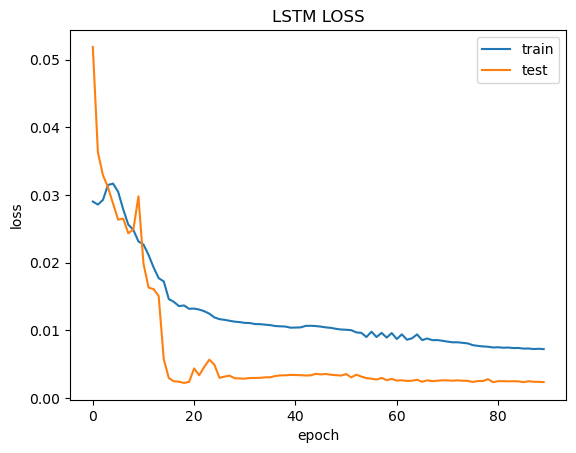

In [38]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# epochs在300左右最佳，本数据集训练时间较久
history = model.fit(train_X, train_y, epochs=90, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
plt.title('LSTM LOSS', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
pyplot.legend()
pyplot.show()

In [39]:
yhat = model.predict(test_X)

313/313 [==============================] - 1s 2ms/step


In [40]:
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
print(yhat.shape)
print(test_X.shape)
inv_yhat = concatenate((yhat, test_X[:, -n_features:-1]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# print(inv_yhat)

# 读取原始的Excel文件
file_path = 'HSI_5分钟线+factor.xlsx'
data = pd.read_excel(file_path)

# 截取第15行到第79108行的数据（Python索引从0开始）
selected_data = data.iloc[start_row:end_row]

# 假设 n_test 是测试集的大小，这里是最后的735行
# 那么，我们需要从selected_data的末尾截取对应数量的行以匹配预测结果
test_data = selected_data.iloc[-n_test:]

# 假设 inv_yhat 包含测试集的预测结果，长度与test_data相匹配
test_data['predict'] = inv_yhat

# 将更新后的DataFrame保存到新的Excel文件中
new_file_path = 'HSI_5分钟线_with_predict.xlsx'
test_data.to_excel(new_file_path, index=False)

(10000, 1)
(10000, 48)


C:\Users\epiph\AppData\Local\Temp\ipykernel_8288\1271567407.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predict'] = inv_yhat


In [41]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -n_features:-1]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# print(inv_y)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 49.098


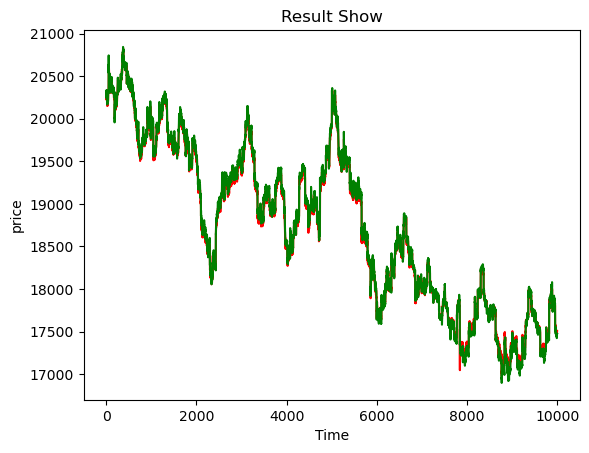

In [42]:
import matplotlib.pyplot as plt
plt.plot(inv_yhat,color='red',label="prediction")
plt.plot(inv_y,color="green",label="real")
plt.title("Result Show")
plt.xlabel("Time")
plt.ylabel("price")
plt.show()

In [44]:
# from datetime import datetime
# pre_data=data[-n_test:]
# pre_data['pre']=inv_yhat
# pre_data['date']=pre_data[-n_test:]

# pre_data['weekday']=pre_data['date'].apply(lambda x:datetime.strptime(x,"%Y-%m-%d").weekday())


In [ ]:
# from nose.util import tolist
# date = tolist(pre_data["date"])
# close_pre = tolist(pre_data["pre"])
# close = tolist(pre_data["收盘"])
# open_prices = tolist(pre_data["开盘"])
# week = tolist(pre_data["weekday"])
# print(date)
# print(week)

In [ ]:
# # 计算年化收益率与最大回撤率
# earn = 0
# max_asset = 0  # 最大资产
# max_d = 0  # 最大资产回落
# day = 0  # 投资天数
# num = 0

# # 初始资金为100000
# init = 1000000
# remain = init

# # 把初始仓位设为0
# position = 0
# day_vol=[]

In [ ]:
# for i in range(3, len(close_pre)):
#     # 投资天数加一
#     day += 1
#     cur_asset = remain + num * float(open_prices[i])
#     day_vol.append(cur_asset)
#     if cur_asset > max_asset:
#         max_asset = cur_asset
#     elif max_asset - cur_asset > max_d:
#         max_d = max_asset - cur_asset
#     # 若没有仓位，当天为星期一，且预测值为上涨，则开仓
#     # 用预测值做决策，调整参数使收益最大，把决策直接用在实际值上计算收益
#     if position == 0 and float(close_pre[i]) > float(close_pre[i - 3]) and week[i] ==0:
#         num = int(init / float(close[i]))
#         remain -= float(close[i]) * num
#         position = (init - float(remain)) / init

#     # 当涨幅大于10%,平掉所有仓位
#     elif position != 0 and float(close_pre[i]) / float(close_pre[i - 1]) >= 1.1:
#         remain += float(close[i]) * num
#         init = remain
#         num = 0
#         position = 0

#     # 当跌幅大于0.7%，平掉所有的仓位
#     elif position != 0 and (float(close_pre[i - 1]) - float(close_pre[i])) / float(close_pre[i - 1]) > 0.004:
#         remain += float(close[i]) * num
#         init = remain
#         num = 0
#         position = 0
#     if date[i] == "2021-11-17" or date[i] == "2022-11-17" or date[i] == "2023-11-17":
#         cur_asset = remain + num * float(open_prices[i])
#         earn = cur_asset - 1000000
#         y_EarnR = (earn / 1000000) / (day / 365)
#         print('年化收益率: {:.2%}'.format(y_EarnR))
#         maxback = max_d / max_asset
#         print('最大回撤率: {:.2%}'.format(maxback))

# remain += float(close[-1]) * num
# print(remain)
# day += 1
# earn = remain - 1000000
# y_EarnR = (earn / 1000000)/ (day / 365)
# print('年化收益率: {:.2%}'.format(y_EarnR))
# maxback = max_d / max_asset
# print('最大回撤率: {:.2%}'.format(maxback))

In [ ]:
# plt.scatter(x=[i for i in range(len(day_vol))],y=day_vol,marker="."
# )
# plt.grid()